In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# SURFACE TEMPERATURE CHANGE 
Data retrieved from IMF (https://climatedata.imf.org/datasets/4063314923d74187be9596f10d034914/about), it shows the change in surface temperature measure against a baseline between 1951-1980.
The objective of this work is to cluster countries based on their annual change, in order to determine how climate change affects surface temperature and variables should be considered to asses risks for different countries.

## Retrieving data

Data of the surface temperature annual change can be downloaded directly from the webpage or through their api services, which is the one used.

In [2]:
url_temp_json = "https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Indicator_3_1_Climate_Indicators_Annual_Mean_Global_Surface_Temperature/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

for i in range(3):
    try:
        response = requests.get(url_temp_json, timeout = 10)
        if response.status_code == 200:
            print("Success")
            data_temp_raw = response.json()
            break
    except requests.exceptions.RequestException as exception:
        print(f"Attempt {i + 1} failed: {exception}")
        time.sleep(2)
    
else:
    print("Failure after max attempts")

Success


In [3]:
features_temp = data_temp_raw.get("features", [])
records_temp = []

for feature in features_temp:
    record = feature["attributes"]
    records_temp.append(record)

## Understanding the data  





In [4]:
df_temp = pd.DataFrame(records_temp)
df_temp.to_csv("assets/IMF_AnnualMeanGlobalSurfaceTemperature.csv")
df_temp.sample(5)

,ObjectId,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023
5,6,Americas,None,AMETMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.724,1.352,1.766,1.353,0.949,1.229,1.303,1.558,1.075,1.772
21,22,Barbados,BB,BRB,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.473,0.923,1.208,0.842,0.552,1.011,0.844,0.859,0.648,NaN
233,239,"Yemen, Rep. of",YE,YEM,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,124,Luxembourg,LU,LUX,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,2.458,1.506,1.857,1.624,2.439,2.122,2.595,1.126,2.887,2.561
195,196,St. Kitts and Nevis,KN,KNA,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.708,1.002,1.174,0.925,0.788,0.879,1.179,0.879,0.787,1.116


In [5]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 73 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ObjectId             236 non-null    int64  
 1   Country              236 non-null    object 
 2   ISO2                 229 non-null    object 
 3   ISO3                 236 non-null    object 
 4   Indicator            236 non-null    object 
 5   Unit                 236 non-null    object 
 6   Source               236 non-null    object 
 7   CTS_Code             236 non-null    object 
 8   CTS_Name             236 non-null    object 
 9   CTS_Full_Descriptor  236 non-null    object 
 10  F1961                201 non-null    float64
 11  F1962                202 non-null    float64
 12  F1963                201 non-null    float64
 13  F1964                200 non-null    float64
 14  F1965                199 non-null    float64
 15  F1966                202 non-null    flo

In [6]:
temp_cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns

temp_unique_vals = {}

for column in temp_cat_cols:
    temp_unique_vals[column] = df_temp[column].unique()

print(temp_unique_vals)


{'Country': array(['Afghanistan, Islamic Rep. of', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Americas', 'Andorra, Principality of', 'Angola',
       'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina',
       'Armenia, Rep. of', 'Aruba, Kingdom of the Netherlands', 'Asia',
       'Australia', 'Austria', 'Azerbaijan, Rep. of', 'Bahamas, The',
       'Bahrain, Kingdom of', 'Bangladesh', 'Barbados',
       'Belarus, Rep. of', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Rep.', 'Chad',
       'Chile', 'China, P.R.: Hong Kong', 'China, P.R.: Macao',
       'China, P.R.: Mainland', 'Colombia', 'Comoros, Union of the',
       'Congo, Dem. Rep. of the', 'Congo, Rep. of', 'Cook Islands',
       'Costa Rica', "Côte d'Ivoire"

Looking into the Country column values, info on continents and the world surface average temperature are also included, so each country will be match with the continent it is in for further group analysis. ISO2 is used to create the dictionary. Contient and World data will be separated from the country table, so each type of region is analyzed separately (neither continents nor world data have ISO2 as Null, this will be the crietaria).

In [7]:
dict_continent_iso2 = {
    "Africa": [
        "DZ", "AO", "BJ", "BW", "BF", "BI", "CM", "CV", "CF", "TD", "KM", "CG", "CD", "CI", "DJ",
        "EG", "GQ", "ER", "SZ", "ET", "GA", "GM", "GH", "GN", "GW", "KE", "LS", "LR", "LY", "MG",
        "MW", "ML", "MR", "MU", "MA", "MZ", "NA", "NE", "NG", "RW", "ST", "SN", "SC", "SL", "SO",
        "ZA", "SS", "SD", "TZ", "TG", "TN", "UG", "EH", "ZM", "ZW", "RE", "SH", "YT"
    ],
    "Asia": [
        "AF", "AM", "AZ", "BH", "BD", "BT", "BN", "KH", "CN", "CY", "GE", "IN", "ID", "IR", "IQ",
        "IL", "JP", "JO", "KZ", "KW", "KG", "LA", "LB", "MY", "MV", "MN", "MM", "NP", "KP", "OM",
        "PK", "PS", "PH", "QA", "SA", "SG", "KR", "LK", "SY", "TJ", "TH", "TR", "TM", "AE", "UZ",
        "VN", "YE", "HK", "MO", "TL", "TW"
    ],
    "Europe": [
        "AL", "AD", "AT", "BY", "BE", "BA", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR", "DE",
        "GR", "HU", "IS", "IE", "IT", "LV", "LI", "LT", "LU", "MT", "MD", "MC", "ME", "NL", "MK",
        "NO", "PL", "PT", "RO", "RU", "SM", "RS", "SK", "SI", "ES", "SE", "CH", "UA", "GB", "VA", 
        "FO", "GI", "IM", "SJ"
    ],
    "Americas": [
        "CA", "MX","US",
        "AG", "BS", "BB", "BZ", "CR", "CU", "DM", "DO", "SV", "GD", "GT", "HT", "HN", "JM", "NI", 
        "PA", "KN", "LC", "VC", "TT", "AI", "GL", "GP", "KY", "MQ", "MS", "PM", "PR", "TC", "VG",
        "VI", "AR", "BO", "BR", "CL", "CO", "EC", "GY", "PY", "PE", "SR", "UY", "VE", "AW", "FK", 
        "GF"
    ],
    "Oceania": [
        "AS", "AU", "CK", "FJ", "PF", "GU", "KI", "MH", "FM", "NR", "NC", "NZ", "NU", "PW", "PG",
        "WS", "SB", "TK", "TO", "TV", "VU", "WF", "NF", "PN"
    ]  
}

In [8]:
df_temp.loc[df_temp.ISO2.isnull()]

,ObjectId,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023
1,2,Africa,None,AFRTMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,1.013,1.190,1.392,1.180,1.178,1.297,1.200,1.396,0.996,1.485
5,6,Americas,None,AMETMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.724,1.352,1.766,1.353,0.949,1.229,1.303,1.558,1.075,1.772
9,10,Antarctica,None,ATATMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.570,-0.020,0.234,0.788,1.451,0.640,0.798,-0.569,0.480,0.480
14,15,Asia,None,ASIATMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,0.929,1.305,1.476,1.480,1.353,1.388,1.506,1.540,1.723,1.778
70,71,Europe,None,EURTMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,1.812,2.092,2.264,1.946,1.987,2.080,3.332,1.583,2.215,2.435
158,159,Oceania,None,OCETMP,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,1.045,0.936,1.108,1.067,1.049,1.306,1.315,0.629,0.745,0.872
232,238,World,None,WLD,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate and Weath...",...,1.047,1.407,1.659,1.429,1.283,1.435,1.682,1.466,1.374,1.767


In [9]:
df_temp_ctry = df_temp.loc[df_temp.ISO2.isnull() == False]
df_temp_world = df_temp.loc[df_temp.Country == "World"]
df_temp_cont = df_temp.loc[(df_temp.ISO2.isnull()) & (df_temp.Country != "World")]

In [10]:
df_temp_ctry_info = df_temp_ctry[["ObjectId", "Country", "ISO2", "ISO3"]]
df_temp_ctry_info.head()

,ObjectId,Country,ISO2,ISO3
0,1,"Afghanistan, Islamic Rep. of",AF,AFG
2,3,Albania,AL,ALB
3,4,Algeria,DZ,DZA
4,5,American Samoa,AS,ASM
6,7,"Andorra, Principality of",AD,AND


In [11]:
df_temp_ctry_reduced = df_temp_ctry.drop(columns = ["ObjectId", "Unit", "Indicator", "Source","CTS_Code", 
                                                    "CTS_Full_Descriptor", "Country", "ISO3", "CTS_Name" ])

df_temp_world_reduced = df_temp_world.drop(columns = ["ObjectId", "Unit", "Indicator", "Source","CTS_Code", 
                                                    "CTS_Full_Descriptor", "Country", "ISO3", "CTS_Name" ])

df_temp_cont_reduced = df_temp_cont.drop(columns = ["ObjectId", "Unit", "Indicator", "Source","CTS_Code", 
                                                    "CTS_Full_Descriptor", "ISO2", "ISO3", "CTS_Name" ])

df_temp_ctry_reduced.describe()

,F1961,F1962,F1963,F1964,F1965,F1966,F1967,F1968,F1969,F1970,...,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023
count,194.000000,195.000000,194.000000,193.000000,192.000000,195.000000,192.000000,192.000000,191.000000,190.000000,...,214.000000,216.000000,216.000000,216.000000,216.000000,215.000000,213.000000,216.000000,216.000000,214.000000
mean,0.164433,-0.030277,-0.021443,-0.091140,-0.248453,0.106867,-0.108776,-0.216182,0.145901,0.100168,...,1.117154,1.263880,1.440898,1.279440,1.304157,1.432056,1.521207,1.317083,1.352815,1.651734
std,0.406020,0.368506,0.413733,0.314502,0.269911,0.423201,0.344785,0.348339,0.333685,0.361046,...,0.587614,0.493574,0.473218,0.405304,0.636896,0.472686,0.619747,0.509005,0.681890,0.599607
min,-0.697000,-1.364000,-2.244000,-0.876000,-1.051000,-2.357000,-1.023000,-3.251000,-1.740000,-1.281000,...,0.130000,-0.132000,0.360000,0.243000,0.302000,0.121000,0.059000,0.042000,-0.698000,0.215000
25%,-0.112750,-0.212000,-0.211250,-0.263000,-0.413000,-0.042000,-0.259500,-0.354500,-0.012000,-0.069750,...,0.708000,0.954000,1.147000,1.005750,0.811500,1.113000,1.111000,0.935750,0.843250,1.179000
50%,0.060000,-0.080000,-0.023500,-0.090000,-0.225000,0.120000,-0.146500,-0.200500,0.200000,0.154500,...,0.949500,1.220500,1.442500,1.243500,1.126000,1.370000,1.418000,1.287500,1.277500,1.601000
75%,0.323000,0.117500,0.200750,0.085000,-0.103750,0.287500,0.010250,-0.056750,0.330500,0.302000,...,1.324750,1.541250,1.710750,1.530750,1.844250,1.694500,1.835000,1.630000,1.865250,2.089000
max,1.894000,1.033000,1.187000,1.083000,0.869000,1.424000,1.143000,0.479000,0.935000,1.000000,...,3.382000,3.313000,5.327000,3.335000,4.064000,2.871000,3.669000,3.012000,3.512000,3.578000


In [12]:
df_temp_ctry_unpivot = pd.melt(df_temp_ctry_reduced, 
                               id_vars=["ISO2"],
                               var_name = "Year",
                               value_name = "Temp_Change")
df_temp_ctry_unpivot["Year_Num"] = df_temp_ctry_unpivot["Year"].str.extract(r'(\d+)$').astype(int)

df_temp_world_unpivot = pd.melt(df_temp_world_reduced, 
                               id_vars=["ISO2"],
                               var_name = "Year",
                               value_name = "Temp_Change")
df_temp_world_unpivot["Year_Num"] = df_temp_world_unpivot["Year"].str.extract(r'(\d+)$').astype(int)

df_temp_cont_unpivot = pd.melt(df_temp_cont_reduced, 
                               id_vars=["Country"],
                               var_name = "Year",
                               value_name = "Temp_Change")
df_temp_cont_unpivot["Year_Num"] = df_temp_cont_unpivot["Year"].str.extract(r'(\d+)$').astype(int)

df_temp_ctry_unpivot.sample(5)

,ISO2,Year,Temp_Change,Year_Num
14293,IQ,F2023,2.064,2023
14249,CU,F2023,1.942,2023
9433,KM,F2002,0.736,2002
8019,AD,F1996,0.563,1996
6886,BD,F1991,0.022,1991


In [13]:
df_temp_ctry_unpivot.sample(5)

,ISO2,Year,Temp_Change,Year_Num
11114,MV,F2009,0.658,2009
7886,JM,F1995,0.897,1995
7259,PH,F1992,0.407,1992
8981,HR,F2000,1.636,2000
13305,BO,F2019,0.985,2019


### World and Continental Analysis


In [14]:
df_temp_world_unpivot["Temp_Change"].describe()

count    63.000000
mean      0.586270
std       0.558179
min      -0.313000
25%       0.158500
50%       0.459000
75%       1.007000
max       1.767000
Name: Temp_Change, dtype: float64

In [15]:
df_temp_world_unpivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ISO2         0 non-null      object 
 1   Year         63 non-null     object 
 2   Temp_Change  63 non-null     float64
 3   Year_Num     63 non-null     int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 1.8+ KB


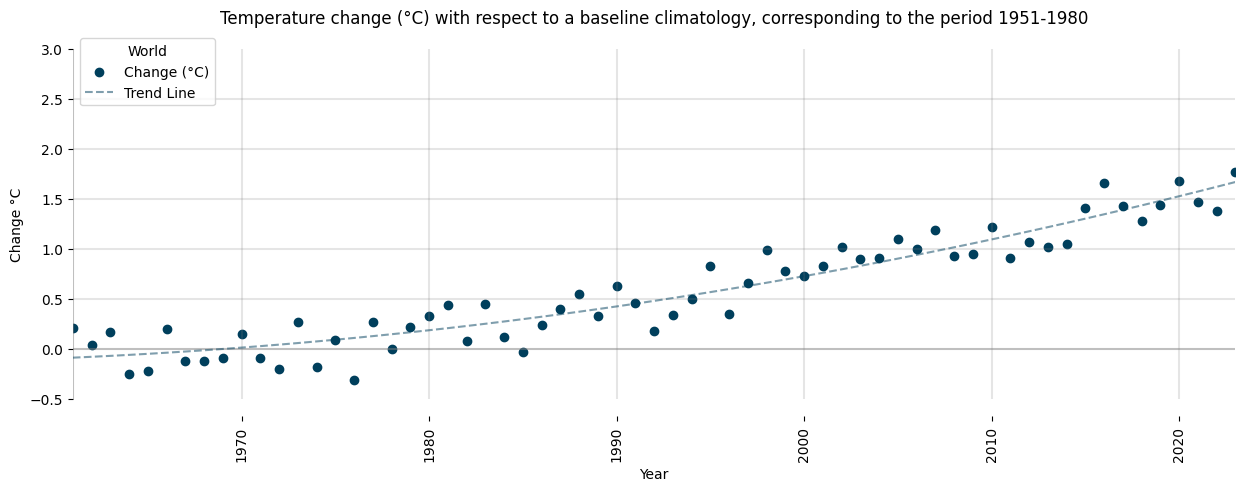

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.hlines(y=0, xmin = 1961, xmax=2023, color = "grey", alpha = 0.5)
plt.hlines(y=0.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=1, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=1.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=2, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=2.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.vlines(x = 1961, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.5)
plt.vlines(x = 1970, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)
plt.vlines(x = 1980, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)
plt.vlines(x = 1990, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)
plt.vlines(x = 2000, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)
plt.vlines(x = 2010, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)
plt.vlines(x = 2020, ymin = -0.5, ymax = 3, color = "grey", alpha = 0.2)

plt.scatter(df_temp_world_unpivot.Year_Num, df_temp_world_unpivot.Temp_Change, 
         c = "#003f5c",
         label = "Change (°C)")

# Fit a trend line using LinearRegression
X = df_temp_world_unpivot.Year_Num.values.reshape(-1, 1)

y = df_temp_world_unpivot.Temp_Change

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
trend_line = model.predict(X_poly)

plt.plot(df_temp_world_unpivot.Year_Num, trend_line, "--", color="#003f5c", alpha = 0.5,label="Trend Line")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlabel("Year")
ax.set_ylabel("Change °C")

plt.title("Temperature change (°C) with respect to a baseline climatology, corresponding to the period 1951-1980")
plt.xticks(rotation = 90)
plt.legend(title = "World", loc = "upper left")
plt.xlim(1961, 2023)
plt.show()

World's temperature has been above the baseline continuously since 1978 (except for 1985). By 1998, the temperature was for the first time above +1°C and since 2012 it has been constantly above 1°C and going upward. Besides the clear increase trend on temperature from baseline, the +0.5 jumps are occurring in shorter periods of time. The trend line takes around 23 years to cross from 0 to +0.5°C, 14 years to cross from +0.5°C to +1°C and 13 years to cross from +1°C to +1.5°C.

In [17]:
df_temp_cont_unpivot["Temp_Change"].describe()

count    378.000000
mean       0.512511
std        0.635433
min       -1.016000
25%        0.063750
50%        0.441000
75%        0.920500
max        3.332000
Name: Temp_Change, dtype: float64

In [18]:
df_temp_cont_unpivot.head()

,Country,Year,Temp_Change,Year_Num
0,Africa,F1961,-0.017,1961
1,Americas,F1961,0.053,1961
2,Antarctica,F1961,0.280,1961
3,Asia,F1961,0.044,1961
4,Europe,F1961,0.881,1961


In [19]:
df_temp_cont_pivot = pd.pivot(df_temp_cont_unpivot, index = "Year", columns = "Country", values = "Temp_Change")
df_temp_cont_pivot.head()

Country,Africa,Americas,Antarctica,Asia,Europe,Oceania
Year,,,,,,
F1961,-0.017,0.053,0.280,0.044,0.881,0.126
F1962,-0.036,-0.084,-0.228,-0.018,0.302,0.150
F1963,0.063,0.264,0.135,0.270,0.103,-0.101
F1964,-0.156,-0.244,-0.366,-0.171,-0.522,-0.021
F1965,-0.201,-0.300,-0.099,-0.028,-0.433,0.087


In [20]:
df_temp_cont_pivot.describe()

Country,Africa,Americas,Antarctica,Asia,Europe,Oceania
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.530000,0.537841,0.178159,0.560698,0.825159,0.443206
std,0.493446,0.562991,0.573023,0.587216,0.900894,0.434578
min,-0.252000,-0.454000,-0.793000,-0.329000,-1.016000,-0.499000
25%,0.123500,0.062500,-0.237000,0.055000,0.171500,0.120000
50%,0.458000,0.506000,0.135000,0.437000,0.724000,0.371000
75%,0.937000,0.894000,0.595500,1.092500,1.501500,0.765000
max,1.501000,1.772000,1.744000,1.778000,3.332000,1.364000


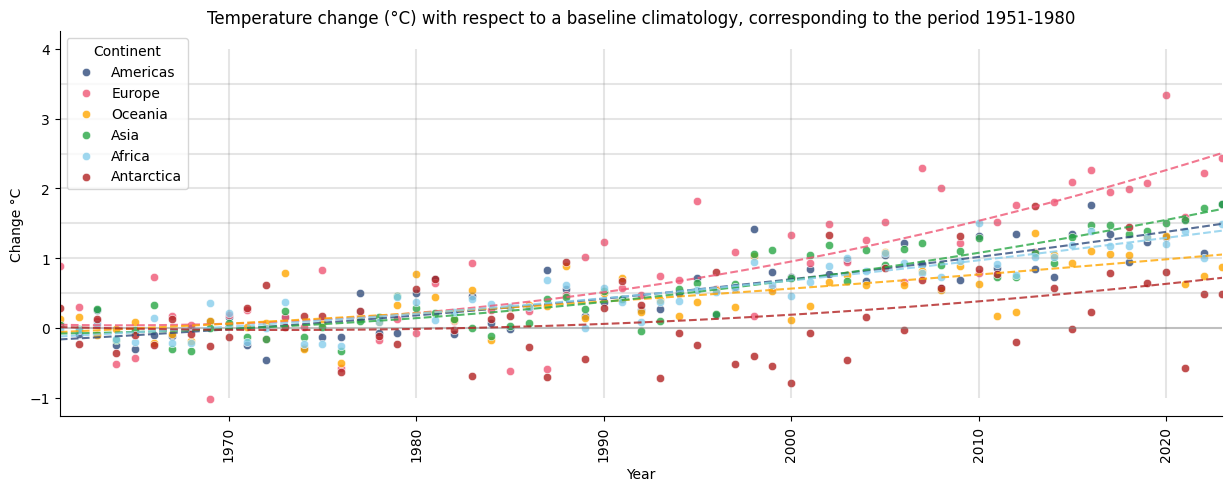

In [21]:
colors_continents = {
    "Americas": "#2f4b7c",
    "Europe": "#ef5675",
    "Oceania": "#ffa600",
    "Asia": "#28a745",
    "Africa": "#87ceeb",
    "Antarctica": "#b22222"
}
import matplotlib.colors

fig, ax = plt.subplots(figsize=(15, 5))

plt.hlines(y=0, xmin = 1961, xmax=2023, color = "grey", alpha = 0.5)
plt.hlines(y=0.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=1, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=1.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=2, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=2.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=3, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.hlines(y=3.5, xmin = 1961, xmax=2023, color = "grey", alpha = 0.2)
plt.vlines(x = 1961, ymin = -1, ymax = 4, color = "grey", alpha = 0.5)
plt.vlines(x = 1970, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)
plt.vlines(x = 1980, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)
plt.vlines(x = 1990, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)
plt.vlines(x = 2000, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)
plt.vlines(x = 2010, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)
plt.vlines(x = 2020, ymin = -1, ymax = 4, color = "grey", alpha = 0.2)

for continent in colors_continents.keys():
    
    continent_data = df_temp_cont_unpivot[df_temp_cont_unpivot.Country == continent]
    sns.scatterplot(data = continent_data,
                 x='Year_Num', y='Temp_Change', 
                 c = colors_continents[continent], alpha = 0.8,
                 label = continent)
    
    # Fit a trend line using LinearRegression
    X = continent_data.Year_Num.values.reshape(-1, 1)
    y = continent_data.Temp_Change

    # Add polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)
    trend_line = model.predict(X_poly)

    plt.plot(continent_data.Year_Num, trend_line, "--", color=colors_continents[continent], alpha = 0.8)
 
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel("Year")
ax.set_ylabel("Change °C")
    
plt.title("Temperature change (°C) with respect to a baseline climatology, corresponding to the period 1951-1980")
plt.xticks(rotation = 90)
plt.xlim(1961, 2023)
plt.legend(title = "Continent")
plt.show()

In [23]:
df_temp_cont_unpivot.pivot(index = "Year", columns = "Country", values = "Temp_Change").reset_index()


Country,Year,Africa,Americas,Antarctica,Asia,Europe,Oceania
0,F1961,-0.017,0.053,0.280,0.044,0.881,0.126
1,F1962,-0.036,-0.084,-0.228,-0.018,0.302,0.150
2,F1963,0.063,0.264,0.135,0.270,0.103,-0.101
3,F1964,-0.156,-0.244,-0.366,-0.171,-0.522,-0.021
4,F1965,-0.201,-0.300,-0.099,-0.028,-0.433,0.087
...,...,...,...,...,...,...,...
58,F2019,1.297,1.229,0.640,1.388,2.080,1.306
59,F2020,1.200,1.303,0.798,1.506,3.332,1.315
60,F2021,1.396,1.558,-0.569,1.540,1.583,0.629
61,F2022,0.996,1.075,0.480,1.723,2.215,0.745


Seems Europe has had the highest increase from baseline, with 2020 being the year with the highest increase from baseline for any continent. Although the Antartica seems to have a lower increase trend, it has to be noticed that the changes year to year have a wider range than the other continents.

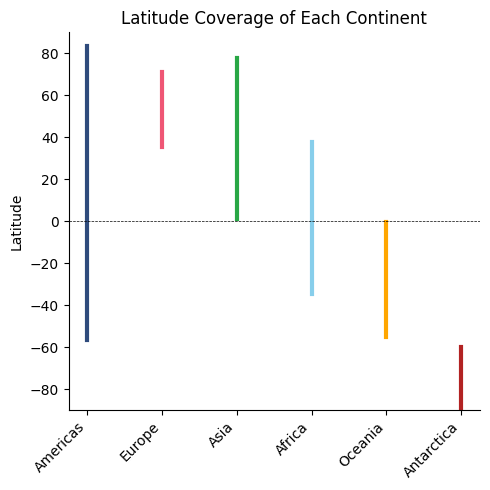

In [24]:
# Data for the northernmost and southernmost points of each continent
dict_cont_lat_lon = {
    "Continent": ["Americas", "Europe", "Asia", "Africa", "Oceania", "Antarctica"],
    "Northernmost Point": [
        {"Latitude": 83.633, "Longitude": -41.500, "Location": "Greenland (Denmark)"},
        {"Latitude": 71.185, "Longitude": 25.783, "Location": "Norway"},
        {"Latitude": 77.711, "Longitude": 104.250, "Location": "Russia (Cape Chelyuskin)"},
        {"Latitude": 37.573, "Longitude": 9.894, "Location": "Tunisia (Cape Angela)"},
        {"Latitude": -0.381, "Longitude": 166.922, "Location": "Nauru"},
        {"Latitude": -60.000, "Longitude": 0.000, "Location": "Antarctica"}
    ],
    "Southernmost Point": [
        {"Latitude": -56.500, "Longitude": -68.000, "Location": "Chile (Cape Horn)"},
        {"Latitude": 35.167, "Longitude": 33.350, "Location": "Cyprus"},
        {"Latitude": 1.255, "Longitude": 103.856, "Location": "Singapore"},
        {"Latitude": -34.835, "Longitude": 20.001, "Location": "South Africa (Cape Agulhas)"},
        {"Latitude": -55.050, "Longitude": 158.716, "Location": "Macquarie Island (Australia)"},
        {"Latitude": -90.000, "Longitude": 0.000, "Location": "Antarctica"}
    ]
}

df_cont_lat_lon = pd.DataFrame(dict_cont_lat_lon)

df_cont_lat_lon["Northernmost Latitude"] = df_cont_lat_lon["Northernmost Point"].apply(lambda x: x["Latitude"])
df_cont_lat_lon["Northernmost Longitude"] = df_cont_lat_lon["Northernmost Point"].apply(lambda x: x["Longitude"])
df_cont_lat_lon["Northernmost Location"] = df_cont_lat_lon["Northernmost Point"].apply(lambda x: x["Location"])

df_cont_lat_lon["Southernmost Latitude"] = df_cont_lat_lon["Southernmost Point"].apply(lambda x: x["Latitude"])
df_cont_lat_lon["Southernmost Longitude"] = df_cont_lat_lon["Southernmost Point"].apply(lambda x: x["Longitude"])
df_cont_lat_lon["Southernmost Location"] = df_cont_lat_lon["Southernmost Point"].apply(lambda x: x["Location"])

df_cont_lat_lon = df_cont_lat_lon.drop(columns=["Northernmost Point", "Southernmost Point"]) #Drop nested columns

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Loop through each continent and plot its coverage
for i, row in df_cont_lat_lon.iterrows():

    continent = row["Continent"]
    ax.plot(
        [i, i],  # x-coordinates for the vertical line
        [row["Southernmost Latitude"], row["Northernmost Latitude"]],  # y-coordinates
        label = continent,
        color=colors_continents[continent],
        linewidth = 3
    )

# Add labels and title
ax.set_xticks(range(len(df_cont_lat_lon)))
ax.set_xticklabels(df_cont_lat_lon["Continent"], rotation=45, ha="right")
ax.set_ylim(-90, 90)
ax.set_ylabel("Latitude")
ax.set_title("Latitude Coverage of Each Continent")
ax.axhline(0, color="black", linewidth=0.5, linestyle="--")  # Equator

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# Show the plot
plt.tight_layout()
plt.show()



Analyzing visually the location of each continent regarding the Equator and the extend of it, seems to be a relation with the actual trend increase in temperature. It can be analyzed in a greater depth by analyzing countries separately. The hypothesis is that countries nearer to the Equator, the higher the increase in average temperature should be registered.

## Country Analysis

### Null Analysis

When dealing with null analysis, there are some common ways to manage them
1. Deleting the entire registry (country). Since we are dealing with timeseries, deleting a year is not recommended.
  
2. Inputing data based on some predefined criteria.  
    a. If a year registration is missing, the mean of the previous and the next year could be used  
    b. If the scope of missing data is more than a year, then other options like using data from high correlated temperature change from other countries could be used.
  
All cases will be analyzed separately to determine the best way to advance in the analysis.


In [25]:
df_temp_null = df_temp_ctry_unpivot.copy()
df_temp_null["Null"] = df_temp_null["Temp_Change"].isnull()

df_temp_null_ctry = df_temp_null.drop(columns = ["Year", "Temp_Change"])
df_temp_null_ctry = df_temp_null_ctry.groupby(by = ["ISO2", "Null"])["Null"].count().reset_index(name='Count')
df_temp_null_ctry = df_temp_null_ctry.loc[df_temp_null_ctry["Null"] == True].sort_values(by = "Count", ascending = False)

df_temp_null_yr = df_temp_null.drop(columns = ["ISO2", "Temp_Change"])
df_temp_null_yr = df_temp_null_yr.groupby(by = ["Year", "Null"])["Null"].count().reset_index(name='Count')

In [31]:
len(df_temp_ctry_unpivot.ISO2.unique())

229

In [26]:
len(df_temp_null_ctry["ISO2"].unique())

74

In [28]:
df_temp_null_ctry.sort_values(by = "Count")

,ISO2,Null,Count
4,AG,True,1
244,SL,True,1
176,MS,True,1
6,AI,True,1
136,KN,True,1
...,...,...,...
223,RS,True,45
257,TC,True,47
233,SD,True,50
250,SS,True,50


In [32]:
df_temp_null_ctry.Count.sum()

1620

In [33]:
len(df_temp_null_ctry.loc[df_temp_null_ctry.Count == 1])

12

The total number of missing values are 1,620 distributed unevenly in 74 countries. 12 countries have only 1 missing value and Virgina has the highest null values count with 57.

In [ ]:
def get_continent(iso2):
    for continent, countries in dict_continent_iso2.items():
        if iso2 in countries:
            return continent
    return "Unknown"

df_temp_null_ctry["Continent"] = df_temp_null_ctry["ISO2"].apply(get_continent)

Text(169.44444444444446, 0.5, 'Records')

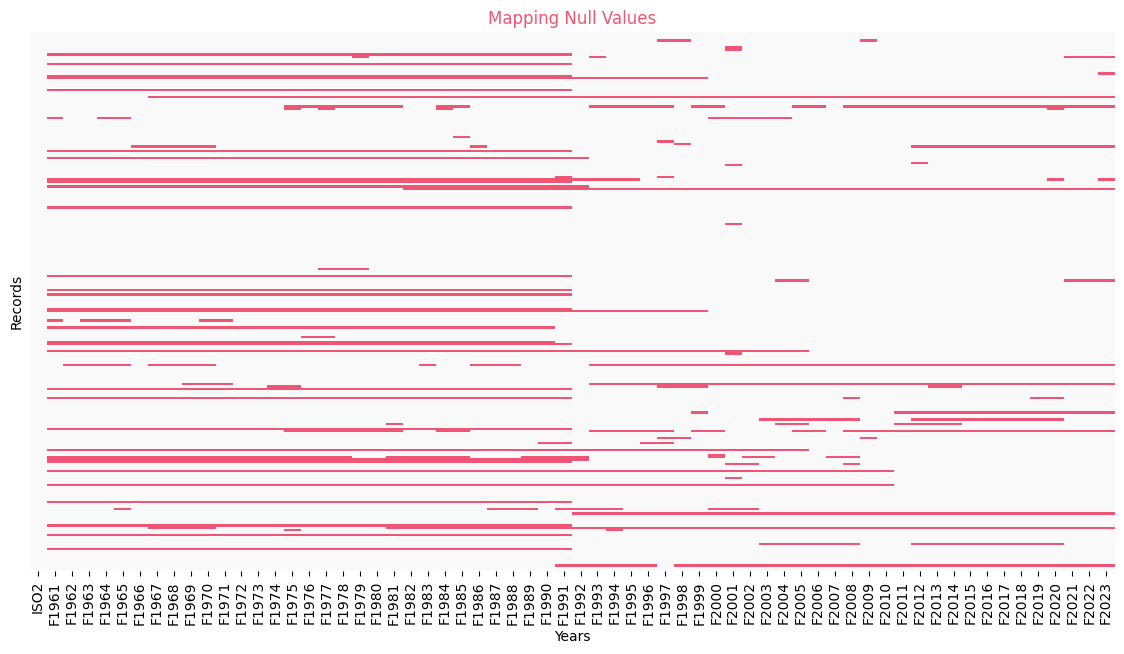

In [35]:
norm = matplotlib.colors.Normalize(0,1)
colors_nulls = [[norm(0.0), "#F9F9F9"],
          [norm( 1.0), "#EF5675"]]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_nulls)

plt.figure(figsize=(14, 7))

ax1 = plt.subplot(1,1,1)

#df_temp_null_ctry["Color"] = df_temp_null_ctry.Continent.map(continent_colors)
sns.heatmap(df_temp_ctry_reduced.isnull(), ax = ax1, yticklabels=False, cbar=False, cmap = cmap)
ax1.set_title("Mapping Null Values", c = "#EF5675")
ax1.set_xlabel("Years")
ax1.set_ylabel("Records")


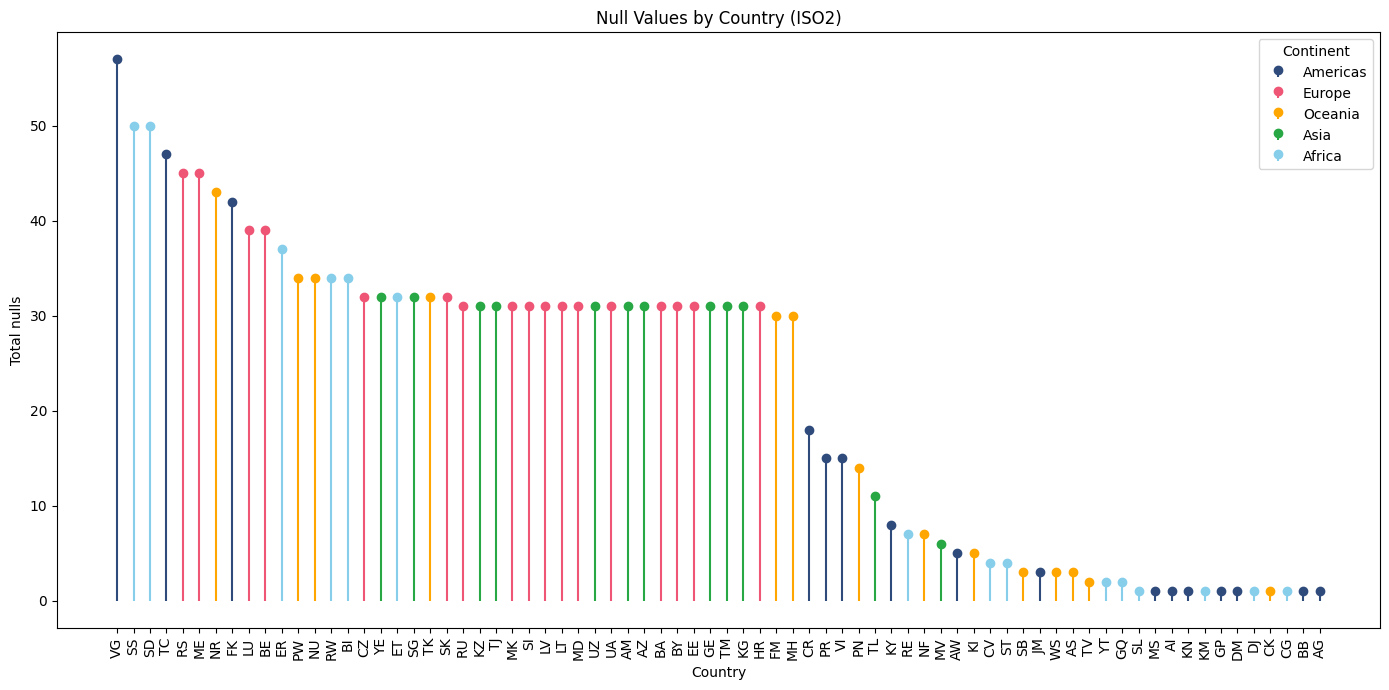

In [ ]:
iso2_range = range(0, len(df_temp_null_ctry.loc[df_temp_null_ctry["Null"] == True]))

plt.figure(figsize=(14, 7))
ax2 = plt.subplot(1,1,1)

for continent in colors_continents.keys():
    if continent != "Antarctica":
        continent_data = df_temp_null_ctry[df_temp_null_ctry["Continent"] == continent]
        x_positions = [
            i for i, iso in enumerate(df_temp_null_ctry["ISO2"]) if iso in continent_data["ISO2"].values
        ]

        # Create stem plot for the specific continent
        ax2.stem(
            x_positions,
            continent_data["Count"],
            linefmt=colors_continents[continent],
            markerfmt="o",
            basefmt=" ",
            label=continent
        )

# Set x-ticks and labels
ax2.set_xticks(range(len(df_temp_null_ctry["ISO2"])))
ax2.set_xticklabels(df_temp_null_ctry["ISO2"], rotation=90)
ax2.set_title("Null Values by Country (ISO2)")
ax2.set_xlabel("Country")
ax2.set_ylabel("Total nulls")
ax2.legend(title = "Continent")

plt.tight_layout()
plt.show()

Additional to considering the years with information, the surface area of each should be considered to determine if a country should be discarded or kept. The information of surface is expressed in $km^2$.

Text(0.06, 50, 'Q05 = 888.25km2')

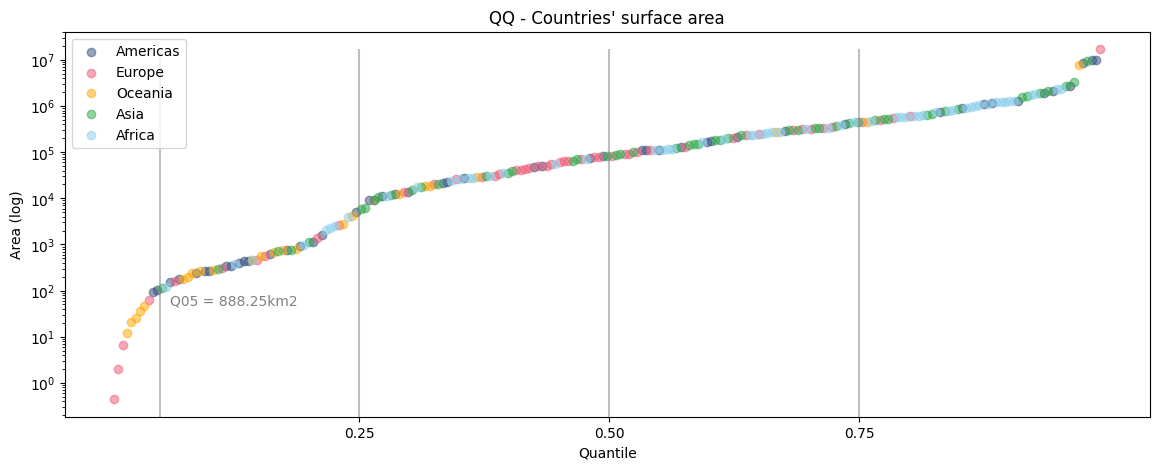

In [39]:
dict_ctry_area = {
    "Africa":{
    "DZ": 2381741, "AO": 1246700, "BJ": 112622, "BW": 581730, "BF": 272967, 
    "BI": 27834, "CM": 475442, "CV": 4033, "CF": 622984, "TD": 1284000, 
    "KM": 2235, "CG": 342000, "CD": 2344858, "CI": 322463, "DJ": 23200, 
    "EG": 1002450, "GQ": 28051, "ER": 117600, "SZ": 17364, "ET": 1104300, 
    "GA": 267668, "GM": 11295, "GH": 238533, "GN": 245857, "GW": 36125, 
    "KE": 580367, "LS": 30355, "LR": 111369, "LY": 1759540, "MG": 587041, 
    "MW": 118484, "ML": 1240192, "MR": 1030700, "MU": 2040, "MA": 446550, 
    "MZ": 801590, "NA": 825615, "NE": 1267000, "NG": 923768, "RW": 26338, 
    "ST": 964, "SN": 196722, "SC": 459, "SL": 71740, "SO": 637657, 
    "ZA": 1221037, "SS": 619745, "SD": 1861484, "TZ": 945087, "TG": 56785, 
    "TN": 163610, "UG": 241038, "EH": 266000, "ZM": 752612, "ZW": 390757, 
    "RE": 2511, "SH": 122, "YT": 374},

    "Asia":{
    "AF": 652230, "AM": 29743, "AZ": 86600, "BH": 765, "BD": 147570, 
    "BT": 38394, "BN": 5765, "KH": 181035, "CN": 9596961, "CY": 9251, 
    "GE": 69700, "IN": 3287263, "ID": 1904569, "IR": 1648195, "IQ": 438317, 
    "IL": 20770, "JP": 377975, "JO": 89342, "KZ": 2724900, "KW": 17818, 
    "KG": 199951, "LA": 236800, "LB": 10452, "MY": 330803, "MV": 298, 
    "MN": 1564110, "MM": 676578, "NP": 147181, "KP": 120538, "OM": 309500, 
    "PK": 881913, "PS": 6220, "PH": 300000, "QA": 11586, "SA": 2149690, 
    "SG": 728, "KR": 100210, "LK": 65610, "SY": 185180, "TJ": 143100, 
    "TH": 513120, "TR": 783562, "TM": 488100, "AE": 83600, "UZ": 447400, 
    "VN": 331212, "YE": 527968, "HK": 1106, "MO": 115.3, "TL": 14874, "TW": 36197},

    "Europe":{
    "AL": 28748, "AD": 468, "AT": 83871, "BY": 207600, "BE": 30528, 
    "BA": 51197, "BG": 110879, "HR": 56594, "CY": 9251, "CZ": 78866, 
    "DK": 42933, "EE": 45227, "FI": 338455, "FR": 551695, "DE": 357022, 
    "GR": 131957, "HU": 93028, "IS": 103000, "IE": 70273, "IT": 301340, 
    "LV": 64589, "LI": 160, "LT": 65300, "LU": 2586, "MT": 316, 
    "MD": 33846, "MC": 2, "ME": 13812, "NL": 41543, "MK": 25713, 
    "NO": 323802, "PL": 312696, "PT": 92090, "RO": 238397, "RU": 17098242, 
    "SM": 61, "RS": 77474, "SK": 49035, "SI": 20273, "ES": 505990, 
    "SE": 450295, "CH": 41285, "UA": 603500, "GB": 243610, "VA": 0.44, 
    "FO": 1393, "GI": 6.5, "IM": 572, "SJ": 61022}, 

    "Americas": {
    "CA": 9984670, "MX": 1964375, "US": 9833517, 
    "AG": 442, "BS": 13943, "BB": 430, "BZ": 22966, "CR": 51100, 
    "CU": 109884, "DM": 751, "DO": 48671, "SV": 21041, "GD": 344, 
    "GT": 108889, "HT": 27750, "HN": 112492, "JM": 10991, "NI": 130375, 
    "PA": 75417, "KN": 261, "LC": 616, "VC": 389, "TT": 5130, 
    "AI": 91, "GL": 2166086, "GP": 1628, "KY": 264, "MQ": 1128, 
    "MS": 102, "PM": 242, "PR": 9104, "TC": 948, "VG": 151, "VI": 346, 
    "AR": 2780400, "BO": 1098581, "BR": 8515767, "CL": 756102, 
    "CO": 1141748, "EC": 283561, "GY": 214969, "PY": 406752, 
    "PE": 1285216, "SR": 163820, "UY": 176215, "VE": 916445, 
    "AW": 180, "FK": 12173, "GF": 83534},

    "Oceania": {
    "AS": 199, "AU": 7692024, "CK": 236, "FJ": 18272, "PF": 4167, 
    "GU": 549, "KI": 811, "MH": 181, "FM": 702, "NR": 21, 
    "NC": 18575, "NZ": 268838, "NU": 260, "PW": 459, "PG": 462840, 
    "WS": 2831, "SB": 28450, "TK": 12, "TO": 747, "TV": 26, 
    "VU": 12189, "WF": 274, "NF": 36, "PN": 47}
}


plt.figure(figsize=(14, 5))

df_ctry_area = pd.DataFrame.from_dict(dict_ctry_area, orient='index').stack().reset_index()
df_ctry_area = df_ctry_area.set_axis(["Continent", "ISO2", "Area"], axis = 1).sort_values(by = "Area", ascending = True)
df_ctry_area["Order"] = df_ctry_area["Area"].rank(method = "dense")
df_ctry_area["qq"] = round(df_ctry_area["Order"] / len(df_ctry_area),4)

plt.vlines(x = 0.05, ymin = 0, ymax = max(df_ctry_area["Area"]), color = "grey", alpha = 0.5)
plt.vlines(x = 0.25, ymin = 0, ymax = max(df_ctry_area["Area"]), color = "grey", alpha = 0.5)
plt.vlines(x = 0.5, ymin = 0, ymax = max(df_ctry_area["Area"]), color = "grey", alpha = 0.5)
plt.vlines(x = 0.75, ymin = 0, ymax = max(df_ctry_area["Area"]), color = "grey", alpha = 0.5)

for continent in colors_continents.keys():
    if continent != "Antarctica":
        continent_data = df_ctry_area[df_ctry_area["Continent"] == continent]
        x_positions = continent_data["qq"]
        y_positions = continent_data["Area"]

        plt.scatter(x = x_positions, y = y_positions, 
                    c=colors_continents[continent], alpha = 0.5,
                    label = continent)

plt.yscale("log")
plt.legend()
plt.title("QQ - Countries' surface area")
plt.xlabel("Quantile")
plt.xticks([0.25, 0.5, 0.75])
plt.ylabel("Area (log)")
plt.annotate("Q05 = " + str(np.percentile(continent_data["Area"], 5)) + "km2", xy = [0.06, 50], c = "grey")

In [44]:
df_ctry_area.to_csv("assets/tbl_CountryArea.csv", index=False)

In [ ]:
country = "ER"
print(df_ctry_area["Area"][df_ctry_area.ISO2 == country])
df_temp_ctry_unpivot["Year"][(df_temp_ctry_unpivot["ISO2"] == country) & (df_temp_ctry_unpivot["Temp_Change"].isnull() == False)].unique()

17    117600.0
Name: Area, dtype: float64


array(['F1996', 'F1997', 'F1998', 'F1999', 'F2000', 'F2001', 'F2002',
       'F2003', 'F2004', 'F2005', 'F2006', 'F2007', 'F2008', 'F2009',
       'F2010', 'F2011', 'F2012', 'F2013', 'F2014', 'F2015', 'F2016',
       'F2017', 'F2018', 'F2019', 'F2021', 'F2022'], dtype=object)


#### Null case management
In general, countries whose records only cover the baseline period (1951–1980) and/or those with more than 10 consecutive years of missing data for small surface areas (below Q05) will be discarded. Other cases will be analyzed based on surface area, years missing, geographical location, and possibilities to input data either through correlation or general trend analysis.  

##### Countries to be discarded
* **British Virgin Islands (VG)**: Only 6 records are available, covering 1961 to 1966, with a surface of 151 $km^2$.  
* **Turks and Caicos Islands (TC)**: Records exist for 1961 - 1966 and 1971 - 1974. Although surface area is above Q05, this records will be discarded.  
* **Nauru (NR)**: Records from 1961, 1966 and the period 1971 - 1978, with a surface of 21 $km^2$.  
* **Falkand Islands (FK)**: Data covers only the period 1961 - 1970. Despite the surface area being above Q05, it will be discarded. 
* **Niue (NU)**: Records span 1961 to 1992, but the surface area is below Q05.  
* **Pitcairn (PN)**: Records cover 1961 to 2010, but the surface area is below Q05.  

##### Input data
* **South Sudan (SS) and Sudan (SD)**: Records are available starting from 2011, when South Sudan became independent. Data for previous years will be input through correlation.  
* **Serbia (RS) and Montenegro (ME)**: Records cover from 2006 - 2023. In 2006, the union formed by Serbia and Montenegro after the breakup of Yugoslavia in 1992 dissolved. Data for previous years will be input through correlation.  
* **Luxemburg (LU)**: Records cover from 2000 to 2023. Data for previous years will be input through correlation.  
* **Belgium (BE)**: Records are available from 2000 to 2023. Data for previous years will be input through correlation.  
* **Eritrea (ER)**: Records cover the periods 1996 - 2019 and 2021 - 2023. Eritrea became independent in 1993. Data up to 1996, will be input through correlation, and data for 2020 will be input as the average of 2019 and 2021.
* **Ethiopia (ET)**: Records begin in 1993, the year Eritrea gained independence from Ethiopia. Data for earlier years will be input through correlation.
* **Palau (PW)**: Records cover the periods 1992 - 2007, 2009 - 2018 and 2021 - 2023. Data for years before 1992 will be input by through correlation. Missing data for 2008 and the 2-year gap from 2019 - 2020 will be input based on the trend.
* **Rwanda (RW)**: Records cover 1961 - 1974, 1982 - 1983, 1986 - 1992, 1998, 2001 - 2004 and 2007. Data for years 1975 - 1981 will be input through correlation, while the following missing periods will be input based on trends.  
* **Burundi (BI)**: Records cover 1961 - 1974, 1982 - 1983, 1986 - 1992, 1998, 2001 - 2004 and 2007. Data for years 1975 - 1981 will be input through correlation, while the following missing periods will be input based on trends.  
* **Czech Rep. (CZ) and Slovakia (SK)**: Records are available for 1993 - 2023. In 1992, Czechoslovakia dissolved into these two independent states. Data for earlier years will be input through correlation.
* **Yemen (YE)**: Records cover from 1961 to 1990 and 1997. Data for 1991 - 1996 will be input based on trends, while data for 1998 - 2023 will be input through correlation.
* **Singapore (SG)**: Records cover 1979 - 1980, 1986 - 1988, 1993 - 1999, 2001, 2004 - 2006, 2009 - 2023. Even when its surface is below Q05, data will be considered because missing records are scattered. Data for years before 1979 will be input through correlation. For periods after 1980 trends will be used.
* **Tokelau (TK)**: Records cover 1979 - 1980, 1986 - 1988, 1993 - 1999, 2001, 2004 - 2006, 2009 - 2023. Despite a surface area below Q05, data will be considered due to the scattered missing records. Data for years up to 1978 will be input through correlation. For periods after 1980 trends will be used.
* **Russia (RU)**: Records begin in 1992, the year the Soviet Union dissolved. Data for earlier years will be input based on Europe's trend, considering Russia represents around 40% of Europe's total surface.
* **Kazakhstan (KZ), Tajikistan (TJ), Turkmenistan (TM), Kyrgyzstan (KG), Slovenia (SI), Latvia (LV), Lithuania (LT), Rep. of Moldova (MD), Uzbekistan (UZ), Ukraine (UA), Armenia (AM), Azerbaijan (AZ), Belarus (BY), Estonia (EE), Georgia (GE)**: Records begin in 1992 after the Soviet Union dissolved. Data for previous years will be input through correlation.
* **North Macedonia (MK), Bosnia and Herzegovina (BA), Croatia (HR)**: Records start in 1992 after Yugoslavia broke apart. Data for earlier years will be input through correlation.
* **Micronesia (FM) and Marshal Islands (MH)**: Records cover 1991 to 2023. Both became independent states in 1986. Data for earlier years will be input through correlation. 
* **Costa Rica (CR)**: Records are available for 1961 - 1965, 1971 - 1985 and 1987 - 2011. Data for 1966 - 1970 will be input through correlation, year 1986 will use the average of 1985 and 1987, and data after 2011 will be based on with trends.
* **Puerto Rico (PR) and US Virgin Islands (VI)**: Records cover 1961 - 2002, 2009 - 2011, and 2021 - 2023. Missing periods will be input through trends.
* **Timor-Leste (TL)**: Records cover 1961 - 1964, 1966 - 1986, 1990, 1995 - 1999, and 2003 - 2023. Data for 1965 will be input through correlation, while other missing periods will be input based on trends.
* **Cayman Islands (KY)**: Records cover 1962 - 1963, 1966 - 1999, and 2005 - 2023. Data for 1961 will replicate 1962 due to a lack of prior data, for years 1964 - 1966 data will be input through correlation, while data for2000 - 2004 will be based on trends.
* **Réunion (RE)**: Records cover 1961 - 1980, 1982 - 2003, 2006 - 2010, and 2015 - 2023. Data for 1981 will use the averae of 1980 and 1982, while other missing periods will be input based on trends.
* **Norfolk Island (NF)**: Records cover 1961 - 1973, 1976 - 1996, 2000 - 2012, and 2015 - 2023. Missing periods will be input based on trends.
* **Maldives (MV)**: Records cover 1962, 1966 - 1969, and 1972 - 2023. Data for 1961 will replicate 1962, while data for 1963 - 1966 and 1970 - 1971 will be input through correlation.
* **Aruba (AW)**: Records cover 1961 - 1978, 1980 - 1992, and 1994 - 2020. Data for years 1979 and 1993 will use the average of the inmediate preceding and following years, and the last 3 years will be input based on trends.
* **Kiribati (KI)**: Records cover 1961 - 2003 and 2006 - 2020. Missing periods will be input based on trends.
* **Cape Verde (CV)**: Records cover 1961 - 1974, 1976, 1978 - 1983, 1985 - 2019 and 2021 - 2023. Missing years will be input using the average of the inmediate preceding and following year.
* **São Tomé and Príncipe (ST)**: Records cover 1961 - 1989, 1992 - 1995, 1998 - 2023. Missing periods will be input based on trends.
* **Solomon Islands (SB)**: Records cover 1961 - 2000, 2003 - 2007 and 2009 - 2023. Missing years, will be input based on trends.
* **Jamaica (JM)**: Records cover 1961 - 1976 and 1980 - 2023. Missing years, will be input based on trends.
* **Samoa (WS) and American Samoa (AS)**: Records cover 1961 - 1996, 1999 - 2008, and 2010 - 2023. Missing years, will be input based on trends.
* **Tuvalu (TV)**: Records cover 1961 - 1996, 1999 - 2008 and 2010 - 2023. Missing years, will be input based on trends.
* **Mayotte (YT)**: Records cover 1961 - 1975, 1978 - 2023. Missing years, will be input based on trends.
* **Equatorial Guinea (EQ)**: Records cover 1961 - 1990, 1992 - 1996 and 1998 - 2023. Missing years, will be input based on trends.
* **Sierra Leone (SL)**: Records cover 1961 - 1999 and 2001 - 2023. Missing years, will be input based on trends.
* **Montserrat (MS)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.
* **Anguilla (AI)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.
* **Saint Kitts and Nevis (KN)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.
* **Comoros (KM)**: Records cover 1961 - 1984 and 1986 - 2023. Missing years, will be input based on trends.
* **Guadeloupe (GP)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.
* **Dominica (DM)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.
* **Djibouti (DJ)**: Records cover 1961 - 2011 and 2013 - 2023. Missing years, will be input based on trends.
* **Cook Islands (CK)**: Records cover 1961 - 1997 and 1999 - 2023. Missing years, will be input based on trends.
* **Congo (CG)**: Records cover 1961 - 1996 and 1998 - 2023. Missing years, will be input based on trends.
* **Barbados (BB)**: Records cover 1961 - 2022. Missing years, will be input based on trends.
* **Antigua and Barbuda (AG)**: Records cover 1961 - 2000 and 2002 - 2023. Missing years, will be input based on trends.


In [42]:
# Re-importing necessary libraries after environment reset
import pandas as pd

# Re-creating the data for the DataFrame
dict_summary_NullsMgt = [
    {
        "ISO2": "VG",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Insufficient records. Small surface."
    },
    {
        "ISO2": "TC",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Scattered records. Small surface."
    },
    {
        "ISO2": "NR",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Records insufficient. Small surface."
    },
    {
        "ISO2": "FK",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Data covers only 1961–1970; dismissed despite surface being above Q05."
    },
    {
        "ISO2": "NU",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Records span 1961–1992; surface is below Q05."
    },
    {
        "ISO2": "PN",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": True,
        "Comments": "Records cover 1961–2010; surface is below Q05."
    },
    {
        "ISO2": "SS",
        "Correlation": np.arange(1961, 2011),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "South Sudan became independent from Sudan in 2011"
    },
    {
        "ISO2": "SD",
        "Correlation": np.arange(1961, 2011),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "South Sudan became independent from Sudan in 2011"
    },
    {
        "ISO2": "RS",
        "Correlation": np.arange(1961, 2006),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 2006, the union formed by Serbia and Montenegro after the breakup of Yugoslavia in 1992, dissolved."
    },
    {
        "ISO2": "ME",
        "Correlation": np.arange(1961, 2006),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 2006, the union formed by Serbia and Montenegro after the breakup of Yugoslavia in 1992, dissolved."
    },
    {
        "ISO2": "LU",
        "Correlation": np.arange(1961, 2000),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "BE",
        "Correlation": np.arange(1961, 2000),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "ER",
        "Correlation": np.arange(1961, 1996),
        "Trend": 0,
        "Average": [2020],
        "Other": 0,
        "Dismissed": False,
        "Comments": "Eritrea became independent from Ethipia in 1993."
    },
    {
        "ISO2": "ET",
        "Correlation": np.arange(1961, 1996),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Eritrea became independent from Ethiopia in 1993."
    },
    {
        "ISO2": "PW",
        "Correlation": np.arange(1961, 1992),
        "Trend": [2008, 2019, 2020],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "RW",
        "Correlation": np.arange(1975, 1982),
        "Trend": [1984, 1985] + list(np.arange(1993, 1998)) + [1999, 2000, 2005, 2006] + list(np.arange(2008, 2024)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "BI",
        "Correlation": np.arange(1975, 1982),
        "Trend": [1984, 1985] + list(np.arange(1993, 1998)) + [1999, 2000, 2005, 2006] + list(np.arange(2008, 2024)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "CZ",
        "Correlation": np.arange(1961, 1993),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Czechoslovakia dissolved into Czech Rep. and Slovakia"
    },
    {
        "ISO2": "SK",
        "Correlation": np.arange(1961, 1993),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Czechoslovakia dissolved into Czech Rep. and Slovakia"
    },
    {
        "ISO2": "YE",
        "Correlation": np.arange(1998, 2024),
        "Trend": np.arange(1991, 1997),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "SG",
        "Correlation": np.arange(1961, 1979),
        "Trend": list(np.arange(1981, 1986)) + list(np.arange(1989, 1993)) + [2000, 2002, 2003, 2007, 2008],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Even when its surface is below Q05, data will be considered because missing records are scattered."
    },
    {
        "ISO2": "TK",
        "Correlation": np.arange(1961, 1979),
        "Trend": list(np.arange(1981, 1986)) + list(np.arange(1989, 1993)) + [2000, 2002, 2003, 2007, 2008],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Even when its surface is below Q05, data will be considered because missing records are scattered."
    },
    {
        "ISO2": "RU",
        "Correlation": 0,
        "Trend": 0,
        "Average": 0,
        "Other": list(np.arange(1961, 1992)),
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved. Missing data will be input based on Europe's trend, considering Russia represents around 40% of Europe's total surface."
    },
    {
        "ISO2": "KZ",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "TJ",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "TM",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "KY",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "SI",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "LV",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "LT",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "MD",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "UZ",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "UA",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "AM",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
         "ISO2": "AZ",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "BY",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "EE",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "GE",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 the Soviet Union dissolved."
    },
    {
        "ISO2": "MK",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 Yugoslavia broke apart."
    },
    {
        "ISO2": "BA",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 Yugoslavia broke apart."
    },
    {
        "ISO2": "HR",
        "Correlation": list(np.arange(1961, 1992)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "In 1992 Yugoslavia broke apart."
    },
    {
        "ISO2": "FM",
        "Correlation": list(np.arange(1961, 1991)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Became independent in 1986"
    },
    {
        "ISO2": "MH",
        "Correlation": list(np.arange(1961, 1991)),
        "Trend": 0,
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": "Became independent in 1986"
    },
    {
        "ISO2": "CR",
        "Correlation": list(np.arange(1966, 1971)),
        "Trend": list(np.arange(2012, 2024)),
        "Average": [1986],
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "PR",
        "Correlation": 0,
        "Trend": list(np.arange(2003, 2009)) + list(np.arange(2012, 2021)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "VI",
        "Correlation": 0,
        "Trend": list(np.arange(2003, 2009)) + list(np.arange(2012, 2021)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "TL",
        "Correlation": list(np.arange(1965, 1966)),
        "Trend": list(np.arange(1987, 1990)) + list(np.arange(2000, 2003)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "KY",
        "Correlation": list(np.arange(1964, 1966)),
        "Trend": list(np.arange(2000, 2005)),
        "Average": 0,
        "Other": [1961],
        "Dismissed": False,
        "Comments": "For 1961, data will be replicated from 1962 due to the lack of prior data."
    },
    {
        "ISO2": "RE",
        "Correlation": 0,
        "Trend": list(np.arange(2004, 2006)) + list(np.arange(2011, 2015)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "NF",
        "Correlation": 0,
        "Trend": list(np.arange(1974, 1976)) + list(np.arange(1997, 2000)) + list(np.arange(2013, 2015)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "MV",
        "Correlation": list(np.arange(1963, 1966)) + list(np.arange(1970, 1972)),
        "Trend": 0,
        "Average": 0,
        "Other": [1961],
        "Dismissed": False,
        "Comments": "For 1961, data will be replicated from 1962 due to the lack of prior data."
    },
    {
        "ISO2": "AW",
        "Correlation": 0,
        "Trend": list(np.arange(2021, 2024)),
        "Average": [1979, 1993],
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "KI",
        "Correlation": 0,
        "Trend": list(np.arange(2003, 2006)) + list(np.arange(2021, 2024)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "CV",
        "Correlation": 0,
        "Trend": 0,
        "Average": [1975, 1977, 1984, 2020],
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "ST",
        "Correlation": 0,
        "Trend": list(np.arange(1990, 1992)) + list(np.arange(1996, 1998)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "SB",
        "Correlation": 0,
        "Trend": list(np.arange(2001, 2003)) + [2008],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "JM",
        "Correlation": 0,
        "Trend": list(np.arange(1977, 1980)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "WS",
        "Correlation": 0,
        "Trend": list(np.arange(1997, 1999)) + [2009],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "AS",
        "Correlation": 0,
        "Trend": list(np.arange(1997, 1999)) + [2009],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "TV",
        "Correlation": 0,
        "Trend": list(np.arange(1997, 1999)) + [2009],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "YT",
        "Correlation": 0,
        "Trend": list(np.arange(1976, 1978)),
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "EQ",
        "Correlation": 0,
        "Trend": [1991, 1997],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "SL",
        "Correlation": 0,
        "Trend": [2000],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "MS",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "AI",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "KN",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "KM",
        "Correlation": 0,
        "Trend": [1985],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "GP",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "DM",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "DJ",
        "Correlation": 0,
        "Trend": [2012],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "CK",
        "Correlation": 0,
        "Trend": [1998],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "CG",
        "Correlation": 0,
        "Trend": [1997],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "BB",
        "Correlation": 0,
        "Trend": [2023],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    },
    {
        "ISO2": "AG",
        "Correlation": 0,
        "Trend": [2001],
        "Average": 0,
        "Other": 0,
        "Dismissed": False,
        "Comments": ""
    }
]

# Creating the DataFrame
df_missing_records = pd.DataFrame(dict_summary_NullsMgt)



In [43]:
df_missing_records.to_csv("assets/tbl_MissingDataImputationStrategy.csv", index = False)

In [45]:
df_temp_ctry_reduced_T = df_temp_ctry_reduced.set_index("ISO2").T
mtx_corr_ctry = df_temp_ctry_reduced_T.corr()
mtx_corr_ctry

ISO2,AF,AL,DZ,AS,AD,AO,AI,AG,AR,AM,...,UZ,VU,VE,VN,WF,PS,EH,YE,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AF,1.000000,0.676372,0.784175,0.680184,0.637883,0.683073,0.684565,0.681026,0.481142,0.683841,...,0.765347,0.710228,0.647874,0.608150,0.705483,0.718613,0.712166,0.519926,0.610485,0.286837
AL,0.676372,1.000000,0.791408,0.726603,0.785887,0.728886,0.624683,0.624513,0.596555,0.667332,...,0.364939,0.671352,0.690007,0.697577,0.724881,0.823376,0.668902,0.149571,0.704913,0.344553
DZ,0.784175,0.791408,1.000000,0.820891,0.789304,0.773370,0.832267,0.830380,0.612703,0.726460,...,0.515639,0.746145,0.795978,0.769045,0.761148,0.756258,0.871696,0.404730,0.773364,0.422024
AS,0.680184,0.726603,0.820891,1.000000,0.710802,0.854273,0.855491,0.857521,0.540175,0.558533,...,0.560218,0.760819,0.859946,0.786346,0.879430,0.705202,0.807808,0.641502,0.815891,0.524351
AD,0.637883,0.785887,0.789304,0.710802,1.000000,0.689935,0.662966,0.666771,0.664756,0.466657,...,0.478519,0.685085,0.686693,0.689370,0.701629,0.574839,0.766568,0.025714,0.700764,0.344123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS,0.718613,0.823376,0.756258,0.705202,0.574839,0.695472,0.616482,0.609142,0.618511,0.893495,...,0.478800,0.659440,0.689687,0.707024,0.712287,1.000000,0.657069,0.346993,0.615700,0.235535
EH,0.712166,0.668902,0.871696,0.807808,0.766568,0.713937,0.811147,0.808985,0.610072,0.553623,...,0.569103,0.715452,0.805845,0.730881,0.729969,0.657069,1.000000,0.276008,0.744776,0.452422
YE,0.519926,0.149571,0.404730,0.641502,0.025714,0.567430,0.384183,0.399562,0.079959,NaN,...,NaN,0.592408,0.334991,0.170152,0.564221,0.346993,0.276008,1.000000,0.417292,0.310824


In [54]:
SD_corr = mtx_corr_ctry.sort_values(by = "SD", ascending = False).head(6)
SD_corr.SD

ISO2
SD    1.000000
PR    0.762809
VI    0.735581
TD    0.681189
ER    0.662153
SS    0.653412
Name: SD, dtype: float64

In [55]:
SD_corr = mtx_corr_ctry.sort_values(by = "SS", ascending = False).head(6)
SD_corr.SS

ISO2
SS    1.000000
VI    0.721762
ER    0.716489
PR    0.684314
SD    0.653412
RE    0.458479
Name: SS, dtype: float64

In [48]:
df_temp_ctry_unpivot.head()

,ISO2,Year,Temp_Change,Year_Num
0,AF,F1961,-0.126,1961
1,AL,F1961,0.635,1961
2,DZ,F1961,0.155,1961
3,AS,F1961,0.121,1961
4,AD,F1961,0.756,1961


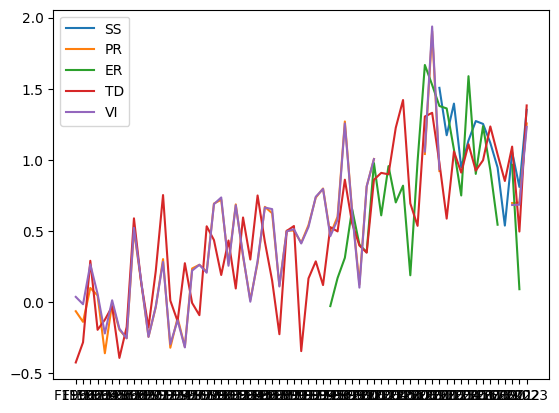

In [53]:
plt.plot(df_temp_ctry_unpivot.Year[df_temp_ctry_unpivot["ISO2"] == "SS"],
         df_temp_ctry_unpivot["Temp_Change"][df_temp_ctry_unpivot["ISO2"] == "SS"],
         label = "SS")
plt.plot(df_temp_ctry_unpivot.Year[df_temp_ctry_unpivot["ISO2"] == "PR"],
         df_temp_ctry_unpivot["Temp_Change"][df_temp_ctry_unpivot["ISO2"] == "PR"],
         label = "PR")
plt.plot(df_temp_ctry_unpivot.Year[(df_temp_ctry_unpivot["ISO2"] == "ER")],
         df_temp_ctry_unpivot["Temp_Change"][(df_temp_ctry_unpivot["ISO2"] == "ER")],
         label = "ER")
plt.plot(df_temp_ctry_unpivot.Year[(df_temp_ctry_unpivot["ISO2"] == "TD")],
         df_temp_ctry_unpivot["Temp_Change"][(df_temp_ctry_unpivot["ISO2"] == "TD")],
         label = "TD")
plt.plot(df_temp_ctry_unpivot.Year[(df_temp_ctry_unpivot["ISO2"] == "VI")],
         df_temp_ctry_unpivot["Temp_Change"][(df_temp_ctry_unpivot["ISO2"] == "VI")],
         label = "VI")
#plt.plot(df_temp_ctry_unpivot.Year[(df_temp_ctry_unpivot["ISO2"] == "TD") & (df_temp_ctry_unpivot["Year"]>"F2010")],
#         df_temp_ctry_unpivot["Temp(°C)_Change"][(df_temp_ctry_unpivot["ISO2"] == "TD") & (df_temp_ctry_unpivot["Year"]>"F2010")],
#         label = "TD")
plt.plot

plt.legend()

**VG**: Virgin Islands will be removed as it only has 6 valid registries from 1961 - 1966
**SS** and **SD**: South Sudan (SS) and Sudan (SD) separated in 2011 after South Sudan declared independence. For these two countries, in order to fill the missing years information

In [ ]:
years = df_temp_ctry_unpivot.Year.unique()
df_temp_clean = df_temp_ctry_unpivot.loc[df_temp_ctry_unpivot.ISO2 != "VG"]

for year in years:
    

In [ ]:
df_temp_clean.loc[(df_temp_clean.ISO2 == "SS") | (df_temp_clean.ISO2 == "SD")]

In [ ]:
dict_ctry_area = {
    #Africa
    "DZ": 2381741, "AO": 1246700, "BJ": 112622, "BW": 581730, "BF": 272967, 
    "BI": 27834, "CM": 475442, "CV": 4033, "CF": 622984, "TD": 1284000, 
    "KM": 2235, "CG": 342000, "CD": 2344858, "CI": 322463, "DJ": 23200, 
    "EG": 1002450, "GQ": 28051, "ER": 117600, "SZ": 17364, "ET": 1104300, 
    "GA": 267668, "GM": 11295, "GH": 238533, "GN": 245857, "GW": 36125, 
    "KE": 580367, "LS": 30355, "LR": 111369, "LY": 1759540, "MG": 587041, 
    "MW": 118484, "ML": 1240192, "MR": 1030700, "MU": 2040, "MA": 446550, 
    "MZ": 801590, "NA": 825615, "NE": 1267000, "NG": 923768, "RW": 26338, 
    "ST": 964, "SN": 196722, "SC": 459, "SL": 71740, "SO": 637657, 
    "ZA": 1221037, "SS": 619745, "SD": 1861484, "TZ": 945087, "TG": 56785, 
    "TN": 163610, "UG": 241038, "EH": 266000, "ZM": 752612, "ZW": 390757, 
    "RE": 2511, "SH": 122, "YT": 374,

    #Asia
    "AF": 652230, "AM": 29743, "AZ": 86600, "BH": 765, "BD": 147570, 
    "BT": 38394, "BN": 5765, "KH": 181035, "CN": 9596961, "CY": 9251, 
    "GE": 69700, "IN": 3287263, "ID": 1904569, "IR": 1648195, "IQ": 438317, 
    "IL": 20770, "JP": 377975, "JO": 89342, "KZ": 2724900, "KW": 17818, 
    "KG": 199951, "LA": 236800, "LB": 10452, "MY": 330803, "MV": 298, 
    "MN": 1564110, "MM": 676578, "NP": 147181, "KP": 120538, "OM": 309500, 
    "PK": 881913, "PS": 6220, "PH": 300000, "QA": 11586, "SA": 2149690, 
    "SG": 728, "KR": 100210, "LK": 65610, "SY": 185180, "TJ": 143100, 
    "TH": 513120, "TR": 783562, "TM": 488100, "AE": 83600, "UZ": 447400, 
    "VN": 331212, "YE": 527968, "HK": 1106, "MO": 115.3, "TL": 14874, "TW": 36197,

    #Europe
    "AL": 28748, "AD": 468, "AT": 83871, "BY": 207600, "BE": 30528, 
    "BA": 51197, "BG": 110879, "HR": 56594, "CY": 9251, "CZ": 78866, 
    "DK": 42933, "EE": 45227, "FI": 338455, "FR": 551695, "DE": 357022, 
    "GR": 131957, "HU": 93028, "IS": 103000, "IE": 70273, "IT": 301340, 
    "LV": 64589, "LI": 160, "LT": 65300, "LU": 2586, "MT": 316, 
    "MD": 33846, "MC": 2, "ME": 13812, "NL": 41543, "MK": 25713, 
    "NO": 323802, "PL": 312696, "PT": 92090, "RO": 238397, "RU": 17098242, 
    "SM": 61, "RS": 77474, "SK": 49035, "SI": 20273, "ES": 505990, 
    "SE": 450295, "CH": 41285, "UA": 603500, "GB": 243610, "VA": 0.44, 
    "FO": 1393, "GI": 6.5, "IM": 572, "SJ": 61022, 

    #Americas
    "CA": 9984670, "MX": 1964375, "US": 9833517, 
    "AG": 442, "BS": 13943, "BB": 430, "BZ": 22966, "CR": 51100, 
    "CU": 109884, "DM": 751, "DO": 48671, "SV": 21041, "GD": 344, 
    "GT": 108889, "HT": 27750, "HN": 112492, "JM": 10991, "NI": 130375, 
    "PA": 75417, "KN": 261, "LC": 616, "VC": 389, "TT": 5130, 
    "AI": 91, "GL": 2166086, "GP": 1628, "KY": 264, "MQ": 1128, 
    "MS": 102, "PM": 242, "PR": 9104, "TC": 948, "VG": 151, "VI": 346, 
    "AR": 2780400, "BO": 1098581, "BR": 8515767, "CL": 756102, 
    "CO": 1141748, "EC": 283561, "GY": 214969, "PY": 406752, 
    "PE": 1285216, "SR": 163820, "UY": 176215, "VE": 916445, 
    "AW": 180, "FK": 12173, "GF": 83534,

    #Oceania
    "AS": 199, "AU": 7692024, "CK": 236, "FJ": 18272, "PF": 4167, 
    "GU": 549, "KI": 811, "MH": 181, "FM": 702, "NR": 21, 
    "NC": 18575, "NZ": 268838, "NU": 260, "PW": 459, "PG": 462840, 
    "WS": 2831, "SB": 28450, "TK": 12, "TO": 747, "TV": 26, 
    "VU": 12189, "WF": 274, "NF": 36, "PN": 47
}


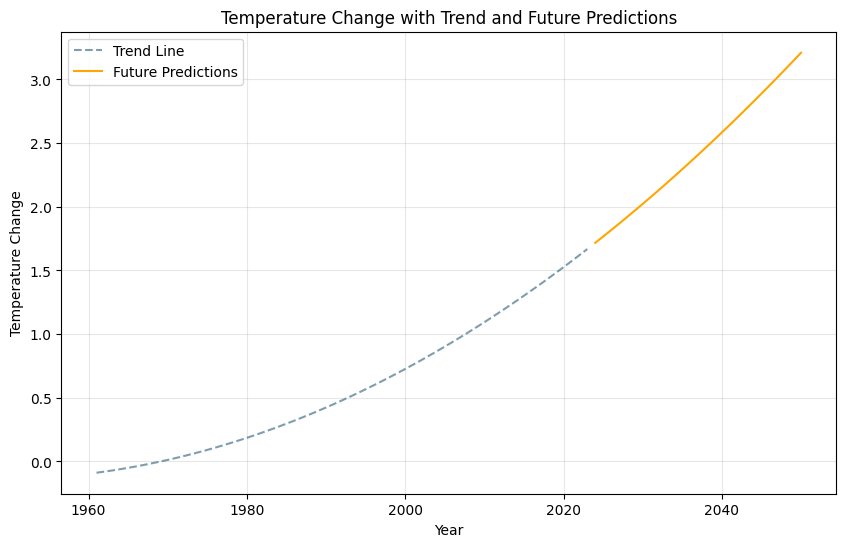

In [ ]:
x_future = np.arange(2024, 2051).reshape(-1, 1)
future_years_poly = poly.transform(x_future)
future_predictions = model.predict(future_years_poly)

# Plot the trend line and prediction line
plt.figure(figsize=(10, 6))
plt.plot(df_temp_world_unpivot.Year_Num, trend_line, "--", color="#003f5c", alpha=0.5, label="Trend Line")
plt.plot(x_future, future_predictions, "-", color="#ffa600", label="Future Predictions")

# Adding labels, title, and legend
plt.title("Temperature Change with Trend and Future Predictions")
plt.xlabel("Year")
plt.ylabel("Temperature Change")
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()
